## Capturing uncertainity in neural nets :

#### $ aleotoric(data$ $ uncertainity )$
    

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax.tree_util as jtu


### Model capturing aleotoric uncertainty
#### dataset containing homoskedastic noise

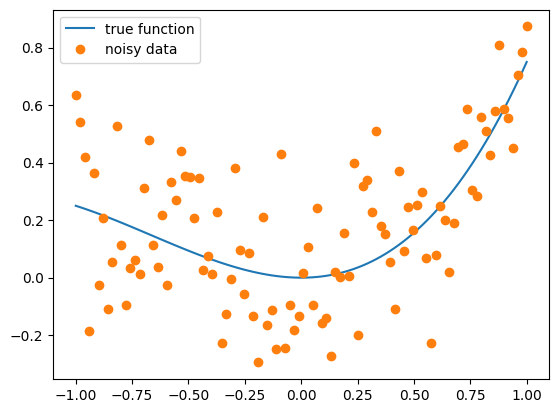

In [44]:
torch.manual_seed(42)
N = 100
x_lin= torch.linspace(-1,1,N)
fun = lambda x: 0.5 * x**2 + 0.25 * x**3
plt.plot(x_lin,fun(x_lin),label='true function');
eps = torch.randn(N) * 0.2
y = fun(x_lin) + eps
plt.plot(x_lin,y,'o',label='noisy data')
plt.legend();




In [45]:
class MeanEstimateNN1(torch.nn.Module):
    def __init__(self,n_hidden=4):
        super().__init__()
        self.fc1 = torch.nn.Linear(1,n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden,n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden,1)

    def forward(self,x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        mu_hat = self.fc3(x)
        return mu_hat        
    


In [46]:
def loss_homoskedastic_noise(model,x,y,params):
    log_noise_std = params['log_noise_std']
    mu_hat = model(x).squeeze()
    assert mu_hat.shape == y.shape
    noise_std=torch.exp(log_noise_std).expand_as(mu_hat)
    dist=torch.distributions.Normal(mu_hat,noise_std)
    return -dist.log_prob(y).mean()

In [47]:
homoskedastic_model_fixed_noise = MeanEstimateNN1()
homoskedastic_model_fixed_noise

MeanEstimateNN1(
  (fc1): Linear(in_features=1, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)

In [48]:
fixed_log_noise_std = torch.log(torch.tensor(0.5))
params = {'nn_params':homoskedastic_model_fixed_noise.state_dict(),
          'log_noise_std':fixed_log_noise_std,}

loss_homoskedastic_noise(homoskedastic_model_fixed_noise,x_lin[:, None],y,params)

tensor(0.6247, grad_fn=<NegBackward0>)

In [49]:
def plot_results(y_hat,epistamic_std=None,aleatoric_std=None,model_name=""):
    plt.scatter(x_lin,y,s=10,color='C0',label='data')
    plt.plot(x_lin,fun(x_lin),color='C1',label='true function')
    plt.plot(x_lin,y_hat,color='C2',label='prediction')
    if epistamic_std is not None:
        plt.fill_between(x_lin,(y_hat-2 * epistamic_std),(y_hat+2 * epistamic_std),color='C2',alpha=0.2,label='epistemic uncertainty')

    if aleatoric_std is not None:
        plt.fill_between(x_lin,(y_hat-2 * aleatoric_std),(y_hat+2 * aleatoric_std),color='C3',alpha=0.2,label='aleatoric uncertainty')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

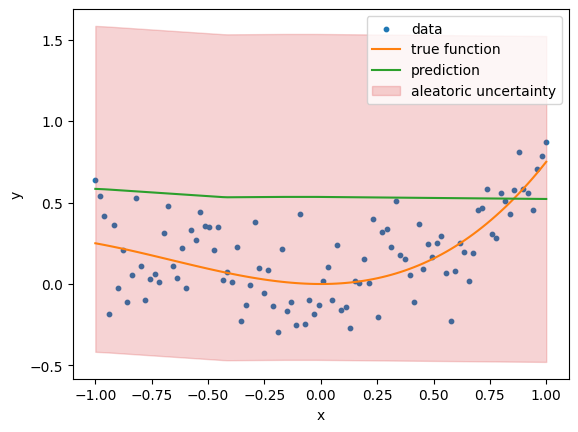

In [50]:
with torch.no_grad():
    y_hat = homoskedastic_model_fixed_noise(x_lin[:, None]).squeeze()
plot_results(y_hat,aleatoric_std=torch.exp(fixed_log_noise_std),model_name='Untrained model')